# SSPs Calibration: Benveniste

Our working local folders for this calibration are contained in the parent folder of this notebook, in _calibration/Benveniste_

The authors of Benveniste et al., 2020 provided us with three data files in the _data_ subfolder, including _all_ssp_em.csv_, _all_ssp_gdp.csv_, and _all_ssp_pop.csv_, which we will post process below.

In [83]:
using Pkg
Pkg.activate(".")
Pkg.add("CSVFiles")
Pkg.add("Query")
Pkg.add("DataFrames")
Pkg.add("Missings")
Pkg.add("VegaLite")

using CSVFiles, Query, DataFrames, Missings, VegaLite

  Activating project at `~/.julia/dev/MimiSSPs/calibration/Benveniste`
   Resolving package versions...
  No Changes to `~/.julia/dev/MimiSSPs/calibration/Benveniste/Project.toml`
  No Changes to `~/.julia/dev/MimiSSPs/calibration/Benveniste/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/dev/MimiSSPs/calibration/Benveniste/Project.toml`
  No Changes to `~/.julia/dev/MimiSSPs/calibration/Benveniste/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/dev/MimiSSPs/calibration/Benveniste/Project.toml`
  No Changes to `~/.julia/dev/MimiSSPs/calibration/Benveniste/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/dev/MimiSSPs/calibration/Benveniste/Project.toml`
  No Changes to `~/.julia/dev/MimiSSPs/calibration/Benveniste/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/dev/MimiSSPs/calibration/Benveniste/Project.toml`
  No Changes to `~/.julia/dev/MimiSSPs/calibration/Benveniste/Manifest.toml`

## Socioeconomic Data

In [84]:
gdp_df = load(joinpath(@__DIR__, "data", "all_ssp_gdp.csv")) |> DataFrame
pop_df = load(joinpath(@__DIR__, "data", "all_ssp_pop.csv")) |> DataFrame

for scen in unique(gdp_df.scen)
    pop_data = pop_df |> @filter(_.scen == scen) |> DataFrame
    gdp_data = gdp_df |> @filter(_.scen == scen) |> DataFrame
    
    # check that keys are the same
    pop_data.period == gdp_data.period
    pop_data.country == gdp_data.country

    df = DataFrame(:year => pop_data.period, 
        :country => pop_data.country, 
        :pop => pop_data.pop ./ 1e3, # convert thousand to million
        :gdp => gdp_data.gdp # billion of USD in $2005
    ) |> save(joinpath(@__DIR__, "..", "..", "data", "socioeconomic", "Benveniste_$(scen).csv"))
end

ArgumentError: ArgumentError: column name :country not found in the data frame

## Emissions Data

Note that for emissions, Benveniste et al., 2020 provides emissions at the country level but here we aggregate to global to fit the expected format of our components.  In addition, Benveniste et al., 2020 only provides CO2 emissions, not CH4, SF6, or N2O, so this will be handled by the components.

In [85]:
em_df = load(joinpath(@__DIR__, "data", "all_ssp_em.csv")) |> DataFrame

scenario_dict = Dict(
    "SSP1-1.9-SPA1" => "SSP119",
    "SSP2-4.5-SPA2" => "SSP245",
    "SSP3-7.0-SPA0" => "SSP370",
    "SSP4-6.0-SPA4" => "SSP460",
    "SSP5-8.5"      => "SSP585"
)

for scenario in unique(em_df.scenario)
    println("Working on emissions for $scenario ...")
    df = DataFrame(:year => [], :carbon_dioxide => [])
    for year in unique(em_df.period)
        em_data = em_df |> 
            @filter(_.scenario == scenario && _.period == year) |> 
            @select(:em_nomig) |> DataFrame

        # sum over countries and convert from Mt CO2 to Gt C
        total_em = 12/44 .* sum(skipmissing(em_data.em_nomig)) ./ 1e3 

        append!(df, DataFrame(:year => year, :carbon_dioxide => total_em)) # sum over countries and convert 
    end
    df |> save(joinpath(@__DIR__, "..", "..", "data", "emissions", "Benveniste_$(scenario_dict[scenario]).csv"))
end

Working on emissions for SSP1-1.9-SPA1 ...
Working on emissions for SSP2-4.5-SPA2 ...
Working on emissions for SSP3-7.0-SPA0 ...
Working on emissions for SSP4-6.0-SPA4 ...
Working on emissions for SSP5-8.5 ...


## Compare 2021 Data to 2024 Data Update

### Population

In [86]:
pop_2024 = load(joinpath(@__DIR__, "data", "all_ssp_pop.csv")) |> DataFrame
pop_2021 = load(joinpath(@__DIR__, "data", "data_2021", "all_ssp_pop.csv")) |> DataFrame

966920×4 DataFrame
    Row │ period  scen    country  pop      
        │ Int64   String  String   Float64  
────────┼───────────────────────────────────
      1 │   1950  SSP1    ABW        38.068
      2 │   1951  SSP1    ABW        38.267
      3 │   1952  SSP1    ABW        38.964
      4 │   1953  SSP1    ABW        40.148
      5 │   1954  SSP1    ABW        41.76
      6 │   1955  SSP1    ABW        43.724
      7 │   1956  SSP1    ABW        45.933
      8 │   1957  SSP1    ABW        48.241
   ⋮    │   ⋮       ⋮        ⋮        ⋮
 966914 │   2994  SSP5    ZWE      7812.17
 966915 │   2995  SSP5    ZWE      7812.17
 966916 │   2996  SSP5    ZWE      7812.17
 966917 │   2997  SSP5    ZWE      7812.17
 966918 │   2998  SSP5    ZWE      7812.17
 966919 │   2999  SSP5    ZWE      7812.17
 966920 │   3000  SSP5    ZWE      7812.17
                         966905 rows omitted

### GDP

In [87]:
gdp_2024 = load(joinpath(@__DIR__, "data", "all_ssp_gdp.csv")) |> DataFrame
gdp_2021 = load(joinpath(@__DIR__, "data", "data_2021", "all_ssp_gdp.csv")) |> DataFrame;

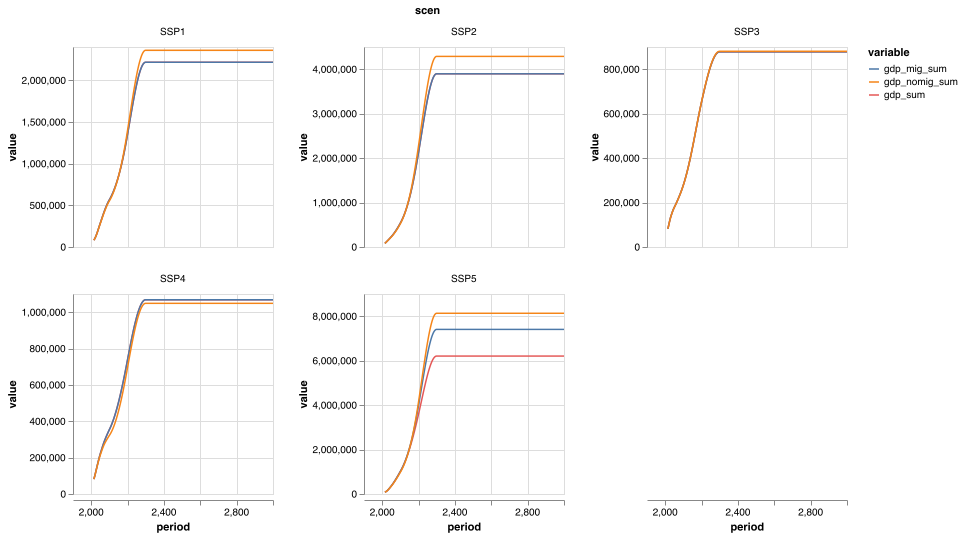

In [88]:
gdf = groupby(gdp_2021, [:period, :scen])
gdp_2021_global = combine(gdf, :gdp => sum)

gdf = groupby(gdp_2024, [:period, :scen])
gdp_2024_global = combine(gdf, :gdp_mig => sum, :gdp_nomig => sum)

df = innerjoin(gdp_2021_global, gdp_2024_global, on = [:period, :scen])

p = stack(df, Not(:period, :scen)) |>
    @vlplot(
        resolve = {scale = {y = :independent}},
        mark = {:line, size = 1.5},
        x = "period:q",
        y = "value:q",
        color = :variable,
        wrap = :scen,
        columns = 3
    )
p |> save(joinpath(@__DIR__, "Compare_GDP.png"), ppi = 300)
p

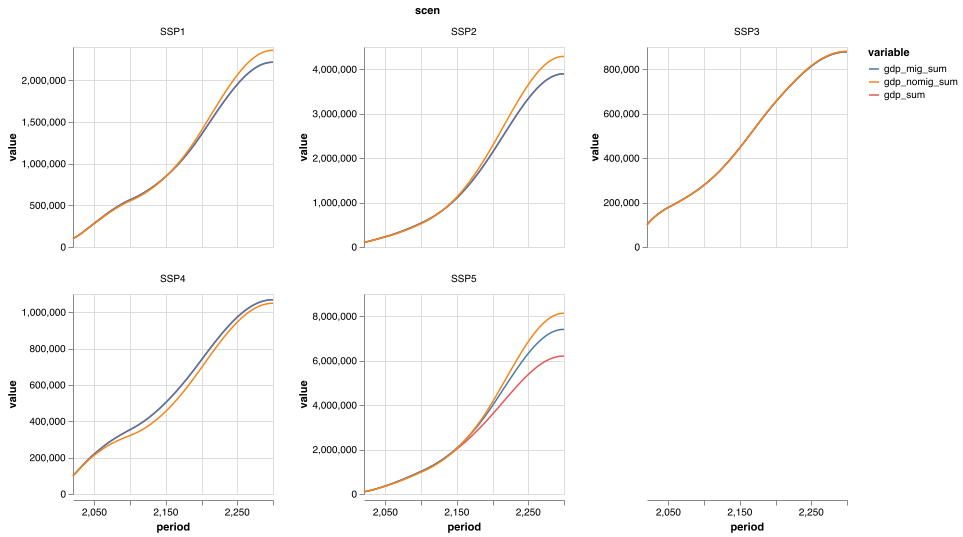

In [89]:
p = stack(df, Not(:period, :scen)) |>
    @filter(_.period in collect(2020:2300)) |>
    @vlplot(
        resolve = {scale = {y = :independent}},
        mark = {:line, size = 1.5},
        x = "period:q",
        y = "value:q",
        color = :variable,
        wrap = :scen,
        columns = 3
    )
p |> save(joinpath(@__DIR__, "Compare_GDP_to2300.png"), ppi = 300)
p

### Emissions

In [90]:
em_2024 = load(joinpath(@__DIR__, "data", "all_ssp_em.csv")) |> DataFrame
em_2021 = load(joinpath(@__DIR__, "data", "data_2021", "all_ssp_em.csv")) |> DataFrame;

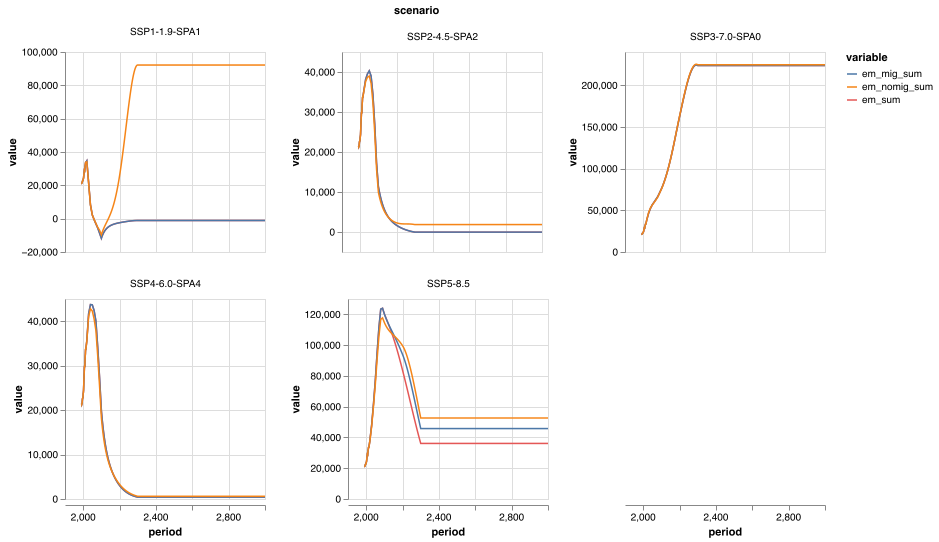

In [91]:
gdf = groupby(em_2021, [:period, :scenario])
em_2021_global = combine(gdf, :em => sum)

gdf = groupby(em_2024, [:period, :scenario])
em_2024_global = combine(gdf, :em_mig => sum, :em_nomig => sum)

df = innerjoin(em_2021_global, em_2024_global, on = [:period, :scenario])

p = stack(df, Not(:period, :scenario)) |>
    @vlplot(
        resolve = {scale = {y = :independent}},
        mark = {:line, size = 1.5},
        x = "period:q",
        y = "value:q",
        color = :variable,
        wrap = :scenario,
        columns = 3
    )
p |> save(joinpath(@__DIR__, "Compare_Emissions.png"), ppi = 300)
p

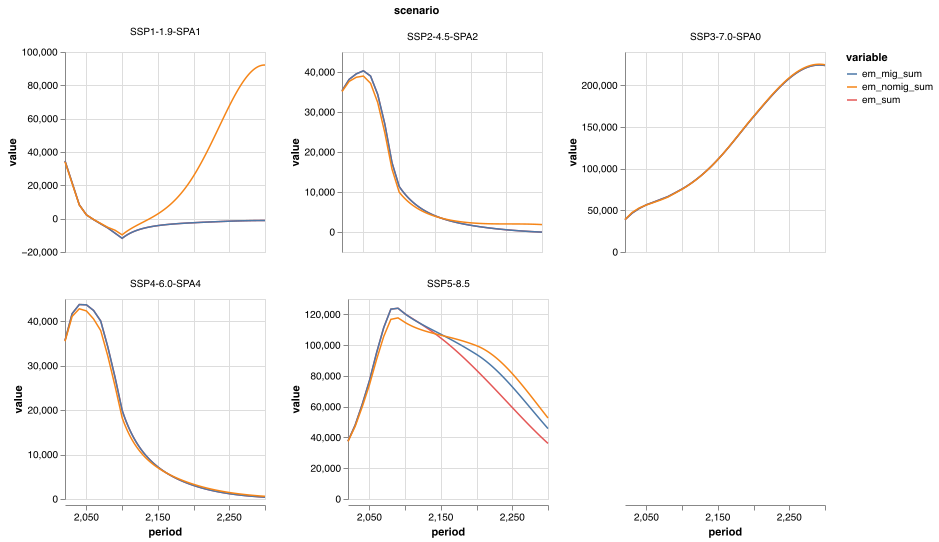

In [95]:
p = stack(df, Not(:period, :scenario)) |>
    @filter(_.period in collect(2020:2300)) |>
    @vlplot(
        resolve = {scale = {y = :independent}},
        mark = {:line, size = 1.5},
        x = "period:q",
        y = "value:q",
        color = :variable,
        wrap = :scenario,
        columns = 3
    )
p |> save(joinpath(@__DIR__, "Compare_Emissions_to2300.png"), ppi = 300)
p